# Predict Fuel Efficiency

This notebook uses the classic Auto MPG Dataset and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. To do this, we'll provide the model with a description of many automobiles from that time period. This description includes attributes like: cylinders, displacement, horsepower, and weight.

In [14]:
# Library imports

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pathlib

In [15]:
# Note this code is only valid if GPU is being used for training

# Before we run the parameter tuning, we will work with little gpu memory allocation
# we will only use that much of memory of gpu as it is needed - allow the growth of gpu memory as it is needed

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Get the dataset and initial Cleanups

In [16]:
# The dataset is available from the UCI Machine Learning Repository.

# We will first download the dataset
dataset_path = tf.keras.utils.get_file("auto-mpg.data", 
                                       "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\FALCON\\.keras\\datasets\\auto-mpg.data'

In [17]:
# import it using pandas

column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
dataset = pd.read_csv(dataset_path, names=column_names, sep=" ", na_values='?', comment='\t', skipinitialspace=True)

# Check initial rows
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [18]:
# Check for missing values
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

There are 6 missing values in horsepower. We will go ahead and delete those corresponding rows

In [19]:
# Dropping the missing values
dataset = dataset.dropna()

In [20]:
# Check the info of the data structure
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   Origin        392 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 27.6 KB


In [21]:
'''
Origin is a categorical variable and not integer where
1 - USA
2 - Europe
3 - Japan
'''

# We will now substitute accordingly
dataset['Origin'] = dataset['Origin'].map(lambda x : {1:'USA', 2:'Europe', 3:'Japan'}.get(x))

# Now let us again check the initial rows of dataset
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,USA
1,15.0,8,350.0,165.0,3693.0,11.5,70,USA
2,18.0,8,318.0,150.0,3436.0,11.0,70,USA
3,16.0,8,304.0,150.0,3433.0,12.0,70,USA
4,17.0,8,302.0,140.0,3449.0,10.5,70,USA


In [22]:
# Lets view Summary statistics
dataset.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000


## Data Visualization

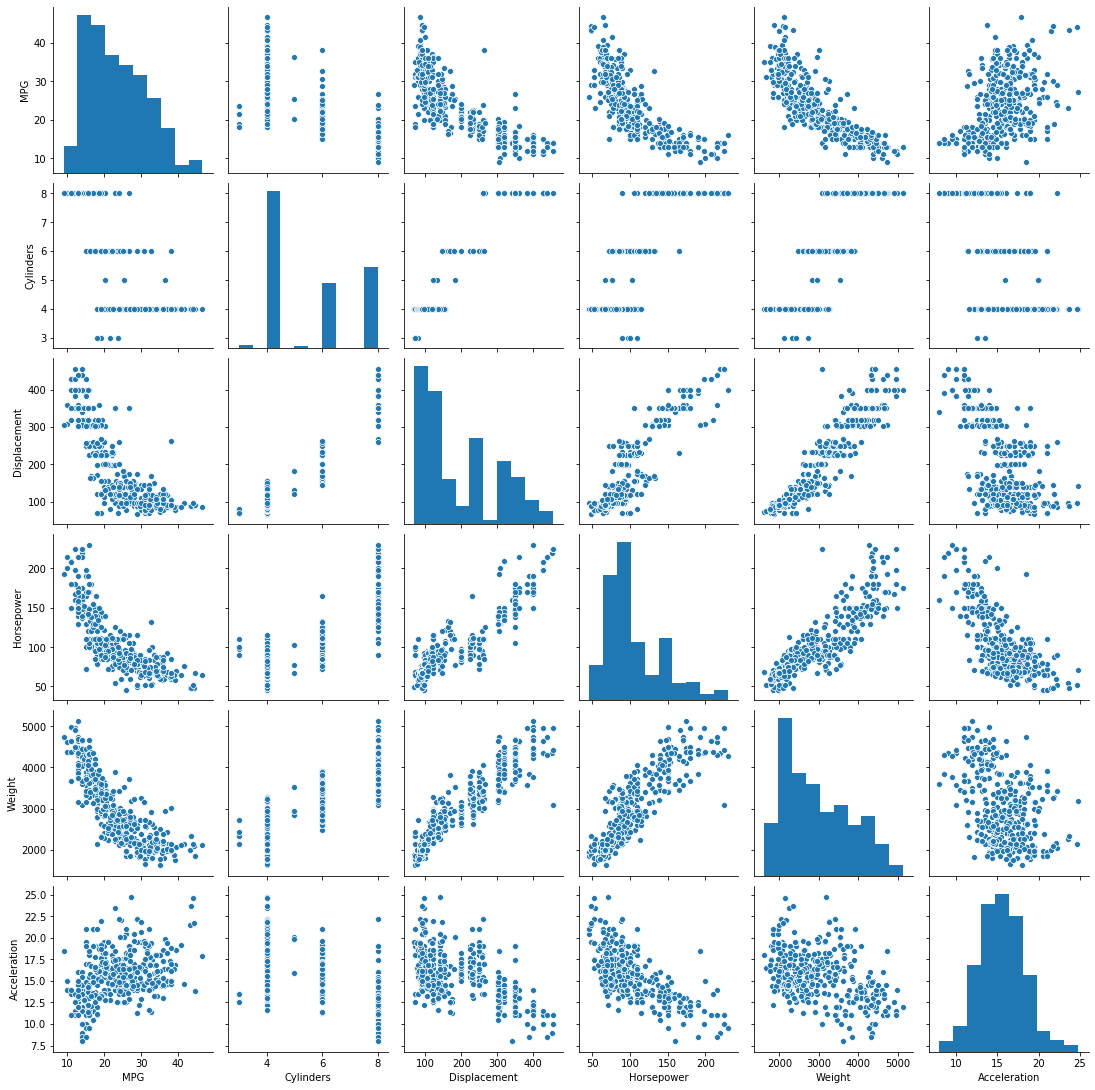

In [23]:
# We will visualize with a pairplot by country of origin
sns.pairplot(dataset[['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Origin']])

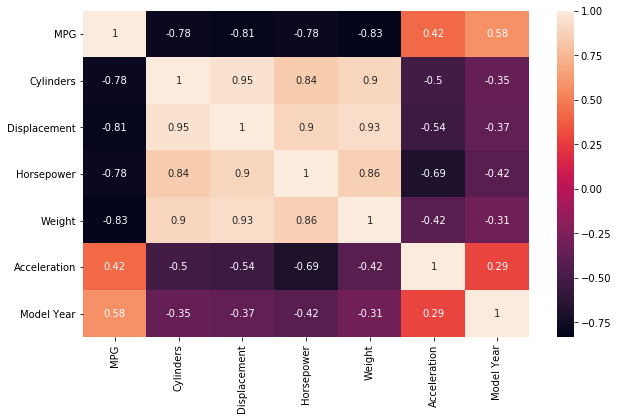

In [24]:
# Lets visualize the correlations
f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(dataset.corr(), annot=True)

## Data Preparation

In [25]:
# We will use one hot encoding for the categorical columns
dataset = pd.get_dummies(data=dataset, prefix='', prefix_sep='', columns=['Origin'], drop_first=True)
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,1


In [26]:
# We will split the features and target variable
dataset.columns

X = dataset[['Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'Model Year', 'Japan', 'USA']].values
y = dataset[['MPG']].values

In [27]:
# Now we will perform variables scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

In [28]:
# Now we will split into training and test 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [29]:
X_train.shape

(313, 8)

In [30]:
y_train.shape

(313, 1)

## Build the Neural Network Model

In [31]:
## NN Model Constants

INPUT_SHAPE = (X_train.shape[1],)
OUTPUT_SHAPE = y_train.shape[1]

NUMBER_UNITS = 64
OUTPUT_UNITS = 1

HIDDEN_ACTIVATION = tf.keras.activations.relu
OUTPUT_ACTIVATION = tf.keras.activations.linear

OPTIMIZER_FUNCTION = tf.keras.optimizers.RMSprop(learning_rate=0.001)
LOSS_FUNCTION = tf.keras.losses.MeanSquaredError()

NUMBER_EPOCHS = 200
BATCH_SIZE = 50
VALIDATION_SPLIT = 0.2

In [32]:
# Build the model

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(input_shape=INPUT_SHAPE, units=NUMBER_UNITS, activation=HIDDEN_ACTIVATION))
model.add(tf.keras.layers.Dense(units=NUMBER_UNITS, activation=HIDDEN_ACTIVATION))
model.add(tf.keras.layers.Dense(units=OUTPUT_UNITS, activation=OUTPUT_ACTIVATION))

# Check the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                576       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Compile the model
model.compile(optimizer=OPTIMIZER_FUNCTION, loss=LOSS_FUNCTION)

In [34]:
# Train the model

epochs_train = model.fit(X_train, y_train, epochs=NUMBER_EPOCHS, 
                         batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)

Train on 250 samples, validate on 63 samples
Epoch 1/200
250/250 [==============================] - 3s 10ms/sample - loss: 0.1712 - val_loss: 0.0607
Epoch 2/200
250/250 [==============================] - 0s 179us/sample - loss: 0.0514 - val_loss: 0.0337
Epoch 3/200
250/250 [==============================] - 0s 128us/sample - loss: 0.0291 - val_loss: 0.0238
Epoch 4/200
250/250 [==============================] - 0s 120us/sample - loss: 0.0199 - val_loss: 0.0207
Epoch 5/200
250/250 [==============================] - 0s 124us/sample - loss: 0.0158 - val_loss: 0.0183
Epoch 6/200
250/250 [==============================] - 0s 124us/sample - loss: 0.0134 - val_loss: 0.0189
Epoch 7/200
250/250 [==============================] - 0s 128us/sample - loss: 0.0119 - val_loss: 0.0153
Epoch 8/200
250/250 [==============================] - 0s 124us/sample - loss: 0.0119 - val_loss: 0.0142
Epoch 9/200
250/250 [==============================] - 0s 124us/sample - loss: 0.0096 - val_loss: 0.0137
Epoch 10/20

Epoch 78/200
250/250 [==============================] - 0s 124us/sample - loss: 0.0034 - val_loss: 0.0068
Epoch 79/200
250/250 [==============================] - 0s 128us/sample - loss: 0.0038 - val_loss: 0.0102
Epoch 80/200
250/250 [==============================] - 0s 124us/sample - loss: 0.0041 - val_loss: 0.0074
Epoch 81/200
250/250 [==============================] - 0s 124us/sample - loss: 0.0029 - val_loss: 0.0077
Epoch 82/200
250/250 [==============================] - 0s 120us/sample - loss: 0.0033 - val_loss: 0.0086
Epoch 83/200
250/250 [==============================] - 0s 128us/sample - loss: 0.0036 - val_loss: 0.0076
Epoch 84/200
250/250 [==============================] - 0s 124us/sample - loss: 0.0037 - val_loss: 0.0074
Epoch 85/200
250/250 [==============================] - 0s 116us/sample - loss: 0.0043 - val_loss: 0.0068
Epoch 86/200
250/250 [==============================] - 0s 124us/sample - loss: 0.0042 - val_loss: 0.0089
Epoch 87/200
250/250 [========================

Epoch 155/200
250/250 [==============================] - 0s 128us/sample - loss: 0.0036 - val_loss: 0.0064
Epoch 156/200
250/250 [==============================] - 0s 124us/sample - loss: 0.0024 - val_loss: 0.0060
Epoch 157/200
250/250 [==============================] - 0s 120us/sample - loss: 0.0032 - val_loss: 0.0070
Epoch 158/200
250/250 [==============================] - 0s 120us/sample - loss: 0.0027 - val_loss: 0.0062
Epoch 159/200
250/250 [==============================] - 0s 124us/sample - loss: 0.0032 - val_loss: 0.0068
Epoch 160/200
250/250 [==============================] - 0s 124us/sample - loss: 0.0032 - val_loss: 0.0072
Epoch 161/200
250/250 [==============================] - 0s 120us/sample - loss: 0.0027 - val_loss: 0.0069
Epoch 162/200
250/250 [==============================] - 0s 120us/sample - loss: 0.0026 - val_loss: 0.0065
Epoch 163/200
250/250 [==============================] - 0s 128us/sample - loss: 0.0030 - val_loss: 0.0070
Epoch 164/200
250/250 [==============

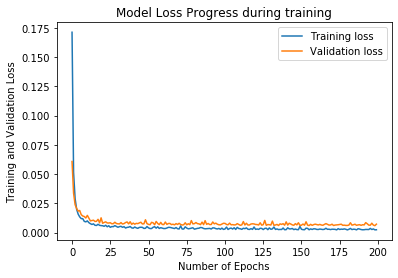

In [35]:
# We will visualize the training loss and validation loss

plt.plot(epochs_train.history['loss'])
plt.plot(epochs_train.history['val_loss'])
plt.title("Model Loss Progress during training")
plt.xlabel("Number of Epochs")
plt.ylabel("Training and Validation Loss")
plt.legend(['Training loss', 'Validation loss'])

## Run model predictions and regression metrics

Text(0.5, 1.0, 'Linear Regression predictions')

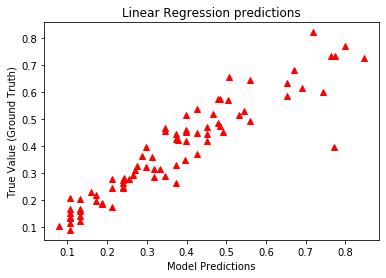

In [36]:
# Run predictions
y_predict = model.predict(X_test)

# Visualize actual vs prediction
plt.plot(y_test, y_predict, '^', color='r')
plt.xlabel("Model Predictions")
plt.ylabel("True Value (Ground Truth)")
plt.title("Linear Regression predictions")

In [37]:
# get the actual values from the scaled values
y_predict_orig = scaler.inverse_transform(y_predict)
y_test_orig = scaler.inverse_transform(y_test)

In [38]:
# Run regression metrics

k = X_test.shape[1]
n = len(X_test)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt

RMSE = float(format(np.sqrt(mean_squared_error(y_test_orig, y_predict_orig)),'.3f'))
MSE = mean_squared_error(y_test_orig, y_predict_orig)
MAE = mean_absolute_error(y_test_orig, y_predict_orig)
r2 = r2_score(y_test_orig, y_predict_orig)
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)

print('RMSE =',RMSE, '\nMSE =',MSE, '\nMAE =',MAE, '\nR2 =', r2, '\nAdjusted R2 =', adj_r2) 

RMSE = 2.758 
MSE = 7.606722851422195 
MAE = 1.9938863947421692 
R2 = 0.860433816584424 
Adjusted R2 = 0.8444833956226439


## Using Linear Regression from sklearn

In [39]:
# We will load the dataset once again

# The dataset is available from the UCI Machine Learning Repository.

# We will first download the dataset
dataset_path = tf.keras.utils.get_file("auto-mpg.data", 
                                       "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
# import it using pandas

column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
dataset = pd.read_csv(dataset_path, names=column_names, sep=" ", na_values='?', comment='\t', skipinitialspace=True)

# We will drop the missing values if any
dataset = dataset.dropna()

# Check initial rows
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [40]:
# Check the info 
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   Origin        392 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 27.6 KB


In [41]:
# Convert the origin column as categorical
dataset['Origin'] = pd.Categorical(dataset['Origin'])

In [42]:
# Necessary imports

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [43]:
# We will split the features and target variable

X = dataset[['Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'Model Year', 'Origin']]
y = dataset['MPG']

In [44]:
# Split into training and test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [45]:
# instantiate Linear regression object

lm = LinearRegression()

# fit the model
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Model evaluation

In [46]:
# We will check the intercepts and coefficients

print("Intercept")
print(lm.intercept_)

# We will relate the coefficients with the training columns
print("\n")
print("Coefficients")
coefDf = pd.DataFrame(lm.coef_[0], X_train.columns, columns=['Coeff'])
coefDf.head()

Intercept
-21.315312086788946


Coefficients


,Coeff
Cylinders,-0.436144
Displacement,-0.436144
Horsepower,-0.436144
Weight,-0.436144
Acceleration,-0.436144


In [47]:
# predictions using the model

predictions = lm.predict(X_test)

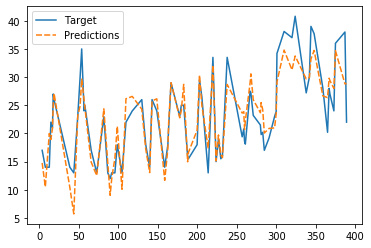

In [48]:
# We will create a small dataframe for target and predictions and visualize the two variables

resultDf = pd.DataFrame({"Target": y_test, "Predictions": predictions})
sns.lineplot(data=resultDf)

Text(0.5, 1.0, 'Target Vs Predictions')

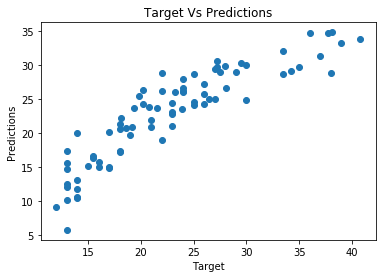

In [49]:
# Another way to visually analyse actual vs predictions
plt.scatter(y_test, predictions)
plt.xlabel("Target")
plt.ylabel("Predictions")
plt.title("Target Vs Predictions")

Text(0.5, 1.0, 'Plot for Residual Errors')

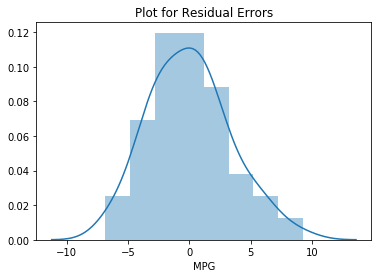

In [50]:
# We will now plot the residual errors

residuals = y_test - predictions
sns.distplot(residuals)
plt.title("Plot for Residual Errors")

We see the distribution plot for residual errors, has a mean of 0(almost!!) and normally distributed

Text(0.5, 1.0, 'Predictions Vs Residuals')

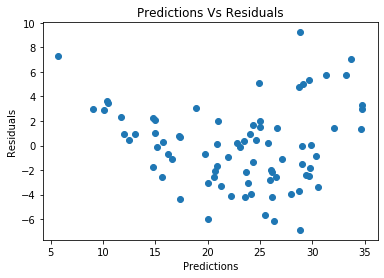

In [51]:
# We will check for heteroskedasticity

plt.scatter(predictions, residuals)
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Predictions Vs Residuals')

We see there is no pattern emerging out from the plot between Predictions and Residuals. Hence we can conclude,
the model doesnt not suffer from heteroskedasticity

#### Regression Evaluation Metrics

Here are three common evaluation metrics for regression problems:
    
*Mean Absolute Error (MAE)* is the mean of the absolute value of the errors:
 
*Mean Squared Error (MSE)* is the mean of the squared errors:
 
*Root Mean Squared Error (RMSE)* is the square root of the mean of the squared errors:
 
Comparing these metrics:
    
MAE is the easiest to understand, because it's the average error.
MSE is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
RMSE is even more popular than MSE, because RMSE is interpretable in the "y" units.
All of these are loss functions, because we want to minimize them.

In [52]:
# to calculate all of these metrics

from sklearn import metrics

print('MAE                  ', metrics.mean_absolute_error(y_test, predictions))
print('MSE                  ', metrics.mean_squared_error(y_test, predictions))
print('RMSE                 ', metrics.mean_squared_error(y_test, predictions))
print('Explained Variance   ', metrics.explained_variance_score(y_test, predictions))

MAE                   2.620172429217371
MSE                   10.819837191236575
RMSE                  10.819837191236575
Explained Variance    0.8014804407549949
